In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from datetime import datetime
from scipy.signal import find_peaks

from sklearn.metrics import confusion_matrix, balanced_accuracy_score

##### Collect Training Data

In [2]:
start_date = datetime(2009, 1, 1)
end_date = datetime(2020, 1, 1)

In [3]:
data = yf.download('UPRO', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
data = data[['Open', 'Close']]

##### Compute Smoothed Features

In [5]:
def MA(series, days=5):
    return series.rolling(window=days).mean()

In [6]:
x = data['Close'].copy()

data.loc[:, '5D-MA'] = MA(x, days=5)
data.loc[:, '10D-MA'] = MA(x, days=10)
data.loc[:, '30D-MA'] = MA(x, days=30)
data.loc[:, '100D-MA'] = MA(x, days=100)

/Users/matthewsmith/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [7]:
train_filt = data.index >= datetime(2010, 1, 1)

In [8]:
plt_filt = data.index < datetime(2013, 1, 1)

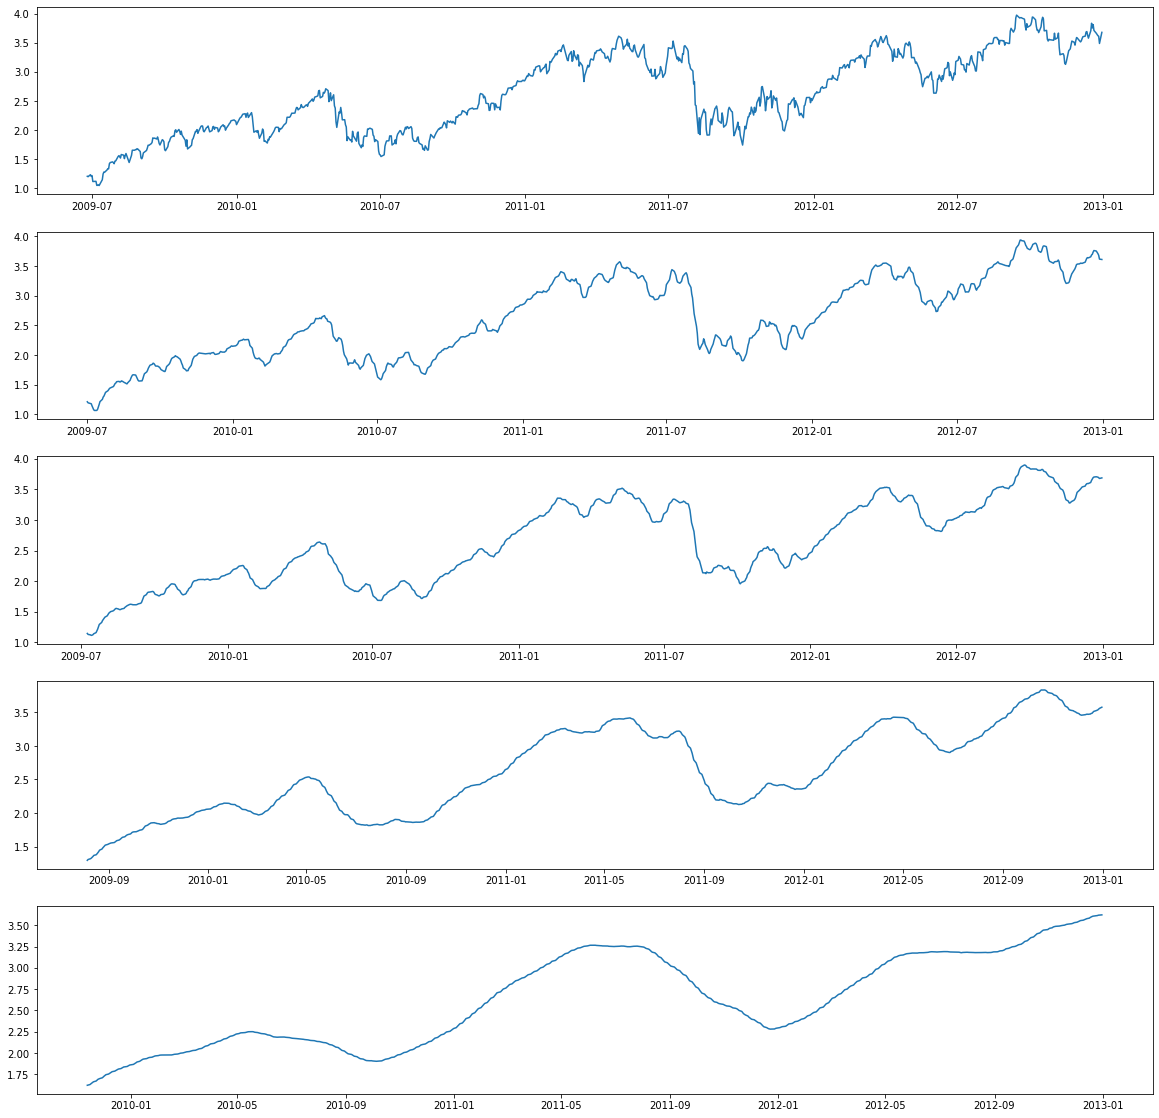

In [9]:
fig, axs = plt.subplots(5, figsize=(20, 20))

axs[0].plot(data['Close'][plt_filt])
axs[1].plot(data['5D-MA'][plt_filt])
axs[2].plot(data['10D-MA'][plt_filt])
axs[3].plot(data['30D-MA'][plt_filt])
axs[4].plot(data['100D-MA'][plt_filt])

##### Compute Price Drops

Questions to Answer: why 10 day moving averages for calculating drops? why is distance set to 30 days?

Eye test that dropdowns are being identified

In [10]:
peaks, _ = find_peaks(data['10D-MA'][train_filt], distance=30)
troughs, _ = find_peaks(-data['10D-MA'][train_filt], distance=30)

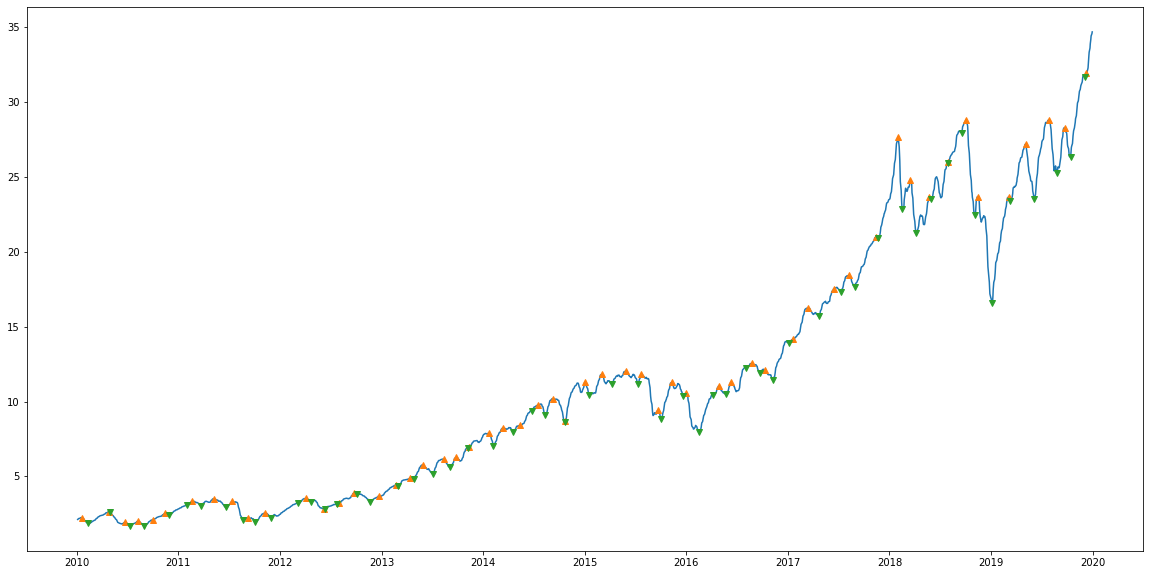

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(data['10D-MA'][train_filt])
plt.plot(data['10D-MA'][train_filt][peaks], '^')
plt.plot(data['10D-MA'][train_filt][troughs], 'v')
plt.show()

In [12]:
len(peaks), len(troughs)

(55, 55)

In [13]:
marks = np.array(list(peaks) + list(troughs))

In [14]:
marks.sort()

In [15]:
is_peak = pd.Series(marks).isin(peaks).values

In [16]:
drawdown_seq = np.array([True, False])

In [17]:
n_array, n_seq = is_peak.size, drawdown_seq.size

r_seq = np.arange(n_seq)

M = (is_peak[np.arange(n_array-n_seq + 1)[:,None] + r_seq] == drawdown_seq).all(1)

In [18]:
ddr = np.array([marks[M.nonzero()[0]].tolist(), marks[M.nonzero()[0]+1].tolist()]).T

In [19]:
ddpc = data['10D-MA'][train_filt][ddr[:, 1]].values / data['10D-MA'][train_filt][ddr[:, 0]].values - 1

Question to Answer: Why 12% drop cutoff?

Equivalent to annualized return of SPY

In [20]:
mddf = ddpc < -0.12

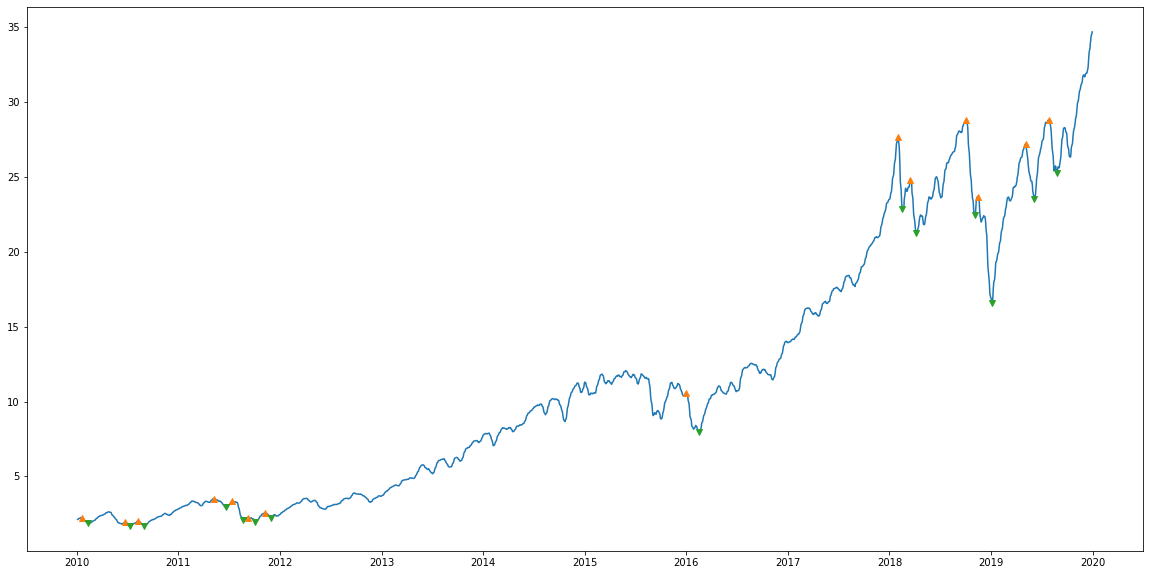

In [21]:
plt.figure(figsize=(20, 10))
plt.plot(data['10D-MA'][train_filt])
plt.plot(data['10D-MA'][train_filt][ddr[:, 0][mddf].astype('int')], '^')
plt.plot(data['10D-MA'][train_filt][ddr[:, 1][mddf].astype('int')], 'v')
plt.show()

##### Compute Signal Training Labels

In [22]:
ranges = ddr[mddf].astype('int')

In [23]:
true_set = []

for i in range(ranges.shape[0]):
    true_set += list(range(ranges[i, 0], ranges[i, 1]+1))

In [24]:
data = data.reset_index()

In [25]:
data['labels'] = data.index.isin(true_set).astype('int')

In [26]:
data = data.set_index('Date')

In [27]:
labels = data['labels']

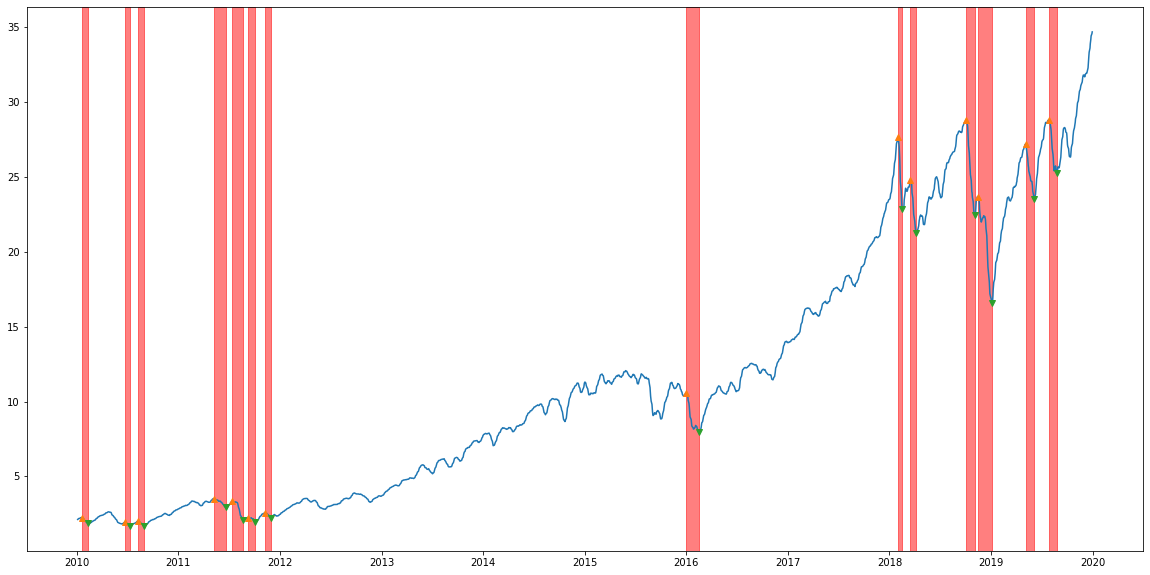

In [28]:
plt.figure(figsize=(20, 10))
plt.plot(data['10D-MA'][train_filt])
plt.plot(data['10D-MA'][train_filt][ddr[:, 0][mddf].astype('int')], '^')
plt.plot(data['10D-MA'][train_filt][ddr[:, 1][mddf].astype('int')], 'v')

for r in ranges:
    plt.axvspan(data[train_filt].index.to_series().iloc[r[0]], data[train_filt].index.to_series().iloc[r[1]], color='red', alpha=0.5)
    
plt.show()

##### Find Optimal Signal on Training Data

In [29]:
optionsA = list(range(5, 105, 5))
optionsB = list(range(1, 25, 1))

In [30]:
def MDD(series, days=5):
    return series.rolling(window=days).min() / series.rolling(window=days).max() - 1

In [31]:
def trading_signal(series, days, thresh):
    stream = MDD(series, days=days)
    stream = stream[stream.index >= datetime(2010, 1, 1)]
    return stream <= -thresh

In [32]:
scores = np.empty((len(optionsA), len(optionsB)))
scores[:] = np.nan

In [33]:
indicator = data['Close'].copy()

Question to Answer: Why use balanced accuracy score?

In [34]:
for i in range(len(optionsA)):
    
    for j in range(len(optionsB)):
        
        days = optionsA[i]
        thresh = optionsB[j] / 100
        
        signal = trading_signal(indicator, days, thresh).astype('int')
        
        scores[i, j] = balanced_accuracy_score(labels[train_filt], signal)

<AxesSubplot:>

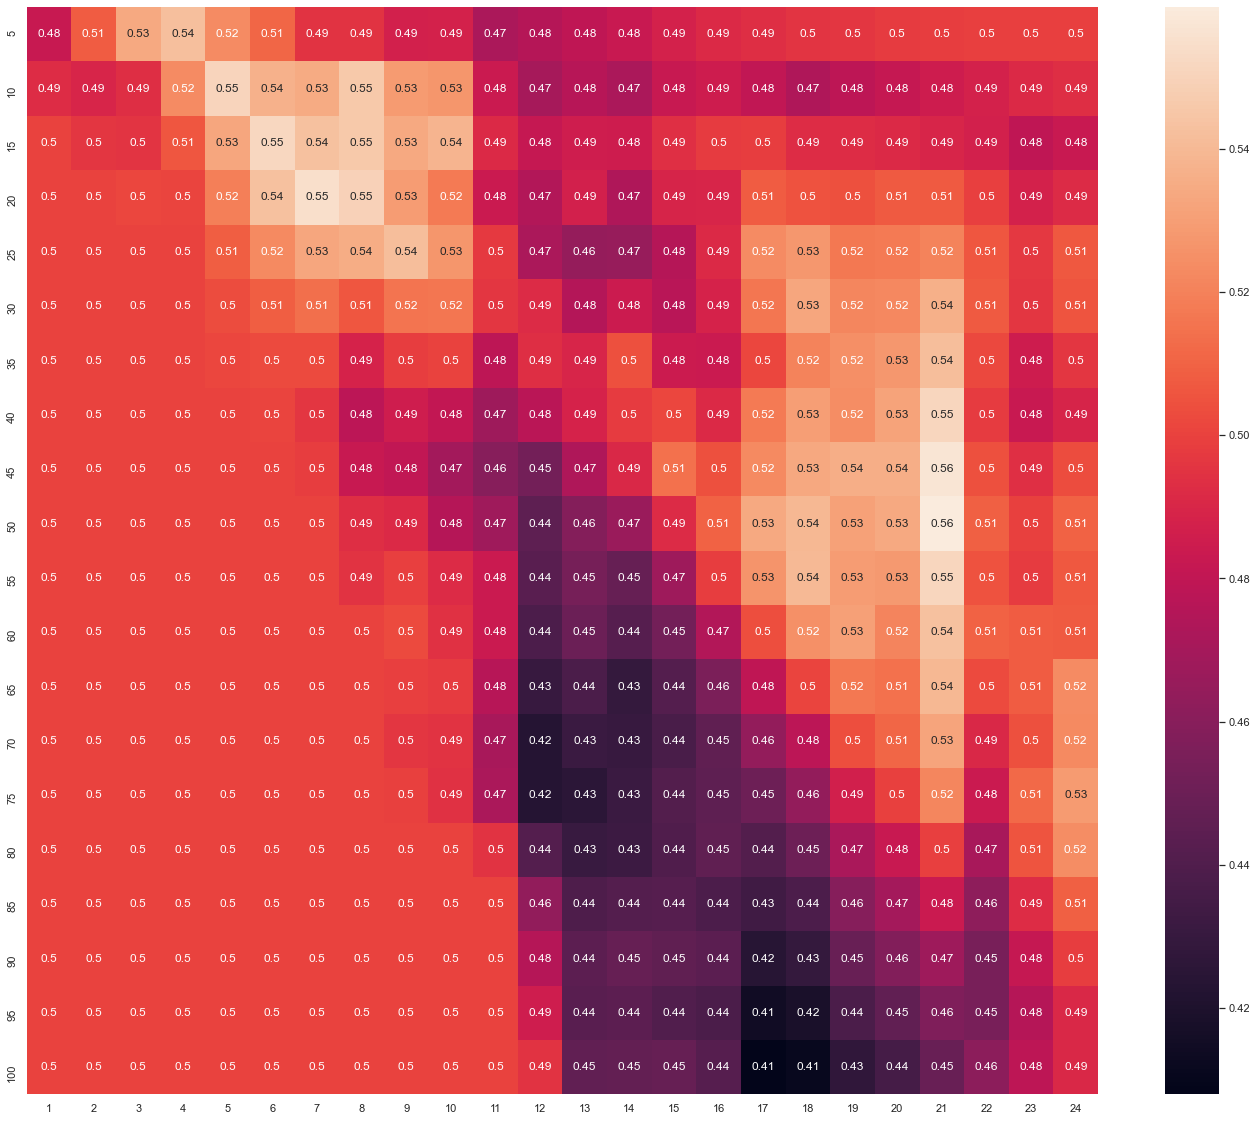

In [35]:
sns.set(rc = {'figure.figsize':(len(optionsB), len(optionsA))})
sns.heatmap(pd.DataFrame(scores, index=optionsA, columns=optionsB), annot=True)

In [36]:
opt_inds = np.unravel_index(scores.argmax(), scores.shape)

In [37]:
optionsA[opt_inds[0]], optionsB[opt_inds[1]] / 100

(50, 0.21)

In [38]:
opt_signal = trading_signal(indicator, optionsA[opt_inds[0]], optionsB[opt_inds[1]] / 100).values.astype(int)

##### Visualize Optimal Signal

In [39]:
confusion_matrix(labels[train_filt], opt_signal)

array([[1204, 1043],
       [ 112,  157]])

In [40]:
start_seq = np.array([0, 1])
stop_seq = np.array([1, 0])

In [41]:
n_array, n_seq = opt_signal.size, start_seq.size

r_seq = np.arange(n_seq)

M = (opt_signal[np.arange(n_array-n_seq + 1)[:,None] + r_seq] == start_seq).all(1)

starts = M.nonzero()[0]

In [42]:
n_array, n_seq = opt_signal.size, stop_seq.size

r_seq = np.arange(n_seq)

M = (opt_signal[np.arange(n_array-n_seq + 1)[:,None] + r_seq] == stop_seq).all(1)

stops = M.nonzero()[0]

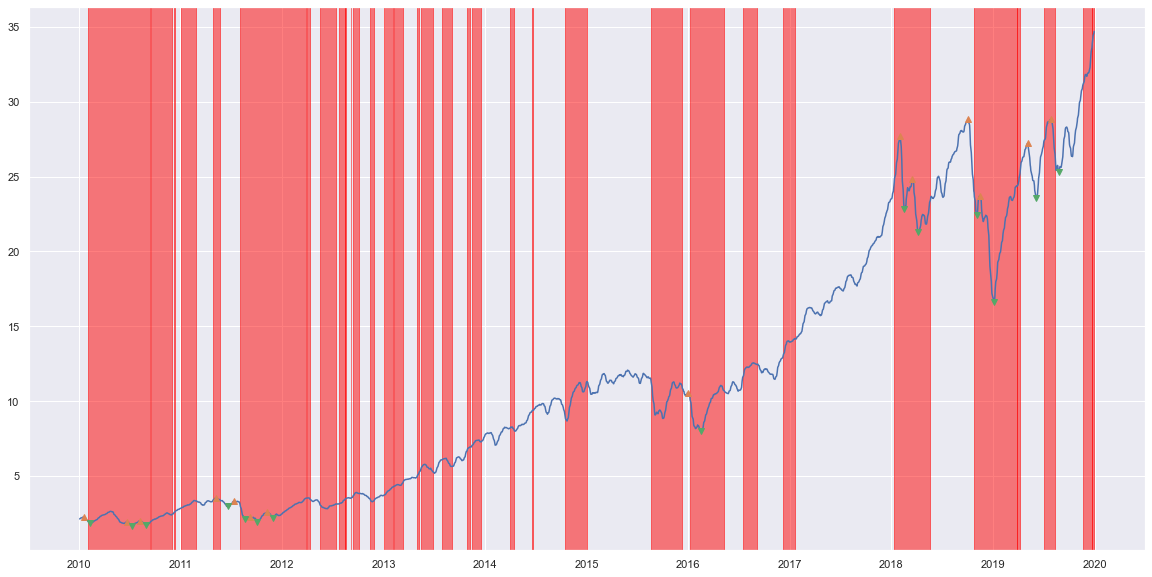

In [43]:
plt.figure(figsize=(20, 10))

plt.plot(data[train_filt]['10D-MA'])
plt.plot(data[train_filt]['10D-MA'][ddr[:, 0][mddf].astype('int')], '^')
plt.plot(data[train_filt]['10D-MA'][ddr[:, 1][mddf].astype('int')], 'v')

if stops.size > starts.size:
    stops = stops[1:]
    
elif stops.size < starts.size:
    starts = starts[:-1]

for i in range(starts.size):
    plt.axvspan(data[train_filt].index.to_series().iloc[starts[i]],
                data[train_filt].index.to_series().iloc[stops[i]], color='red', alpha=0.5)
    
plt.show()

##### Validating Signal

In [44]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 1, 1)

In [45]:
val_data = yf.download('UPRO', start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [46]:
val_data = val_data[['Open', 'Close']]

In [47]:
x = val_data['Close'].copy()

val_data.loc[:, '10D-MA'] = MA(x, days=10)

In [48]:
val_data.loc[:, 'signal'] = trading_signal(x, 50, 0.21)

In [49]:
val_data = val_data[val_data.index >= datetime(2020, 1, 1)]

In [50]:
peaks, _ = find_peaks(val_data['10D-MA'], distance=25)
troughs, _ = find_peaks(-val_data['10D-MA'], distance=20)

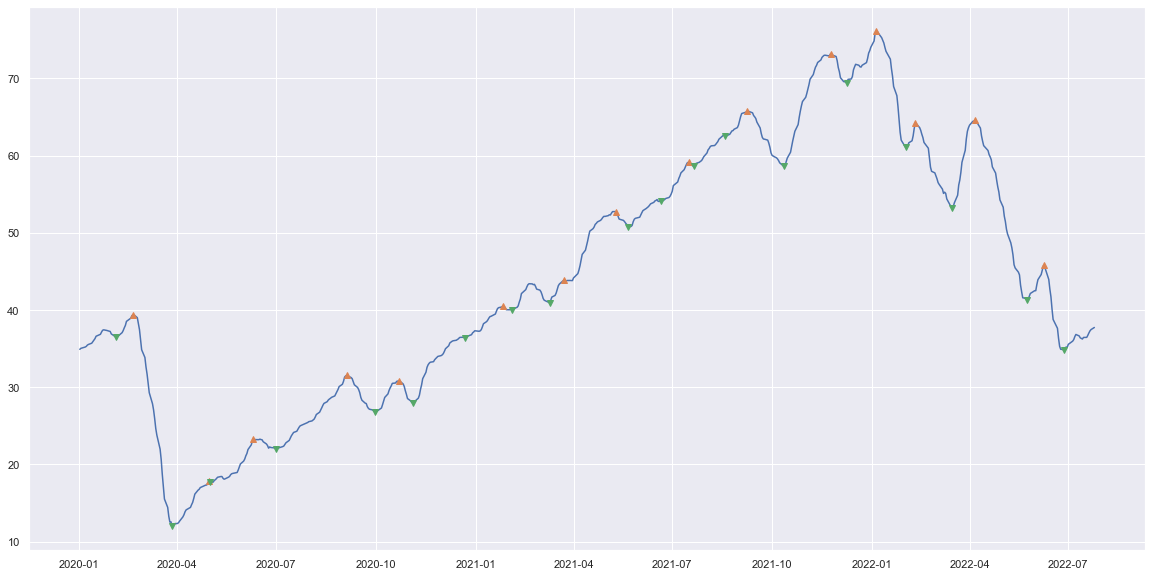

In [51]:
plt.figure(figsize=(20, 10))
plt.plot(val_data['10D-MA'])
plt.plot(val_data['10D-MA'][peaks], '^')
plt.plot(val_data['10D-MA'][troughs], 'v')
plt.show()

In [52]:
len(peaks), len(troughs)

(15, 19)

In [53]:
marks = np.array(list(peaks) + list(troughs))

In [54]:
marks.sort()

In [55]:
is_peak = pd.Series(marks).isin(peaks).values

In [56]:
drawdown_seq = np.array([True, False])

In [57]:
n_array, n_seq = is_peak.size, drawdown_seq.size

In [58]:
r_seq = np.arange(n_seq)

In [59]:
M = (is_peak[np.arange(n_array-n_seq + 1)[:,None] + r_seq] == drawdown_seq).all(1)

In [60]:
ddr = np.array([marks[M.nonzero()[0]].tolist(), marks[M.nonzero()[0]+1].tolist()]).T

In [61]:
ddpc = val_data['10D-MA'][ddr[:, 1]].values / val_data['10D-MA'][ddr[:, 0]].values - 1

In [62]:
mddf = ddpc < -0.12

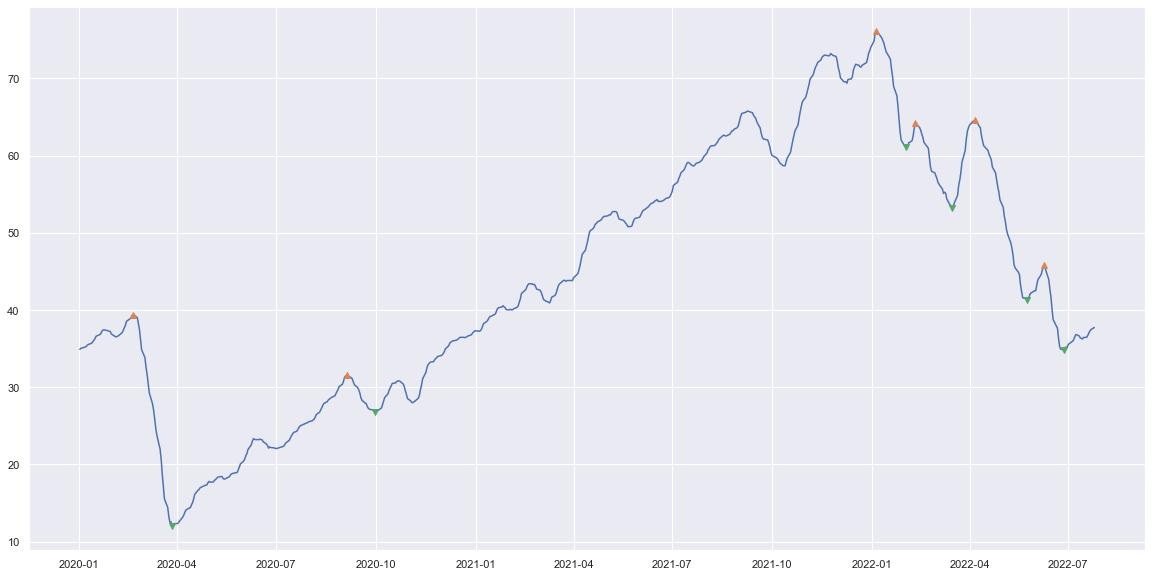

In [63]:
plt.figure(figsize=(20, 10))
plt.plot(val_data['10D-MA'])
plt.plot(val_data['10D-MA'][ddr[:, 0][mddf].astype('int')], '^')
plt.plot(val_data['10D-MA'][ddr[:, 1][mddf].astype('int')], 'v')
plt.show()

In [64]:
ranges = ddr[mddf].astype('int')

In [65]:
true_set = []

for i in range(ranges.shape[0]):
    true_set += list(range(ranges[i, 0], ranges[i, 1]+1))

In [66]:
val_data = val_data.reset_index()

In [67]:
val_data['labels'] = val_data.index.isin(true_set).astype('int')

In [68]:
val_data = val_data.set_index('Date')

In [69]:
opt_signal = val_data['signal'].values.astype('int')
labels = val_data['labels'].values

In [70]:
balanced_accuracy_score(labels, opt_signal)

0.6297572801355259

In [71]:
confusion_matrix(labels, opt_signal)

array([[186, 325],
       [ 14, 120]])